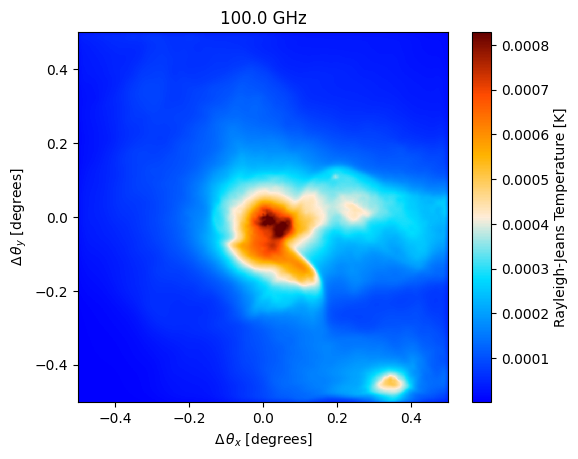

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import maria

import jax.numpy as jnp

map_filename = maria.io.fetch("maps/big_cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename,
                                width=1., #degrees
                                index=1,
                                center=(300.0, -10.0), #RA and Dec in degrees
                                units ='Jy/pixel'
                               )

input_map.to(units="K_RJ").plot()

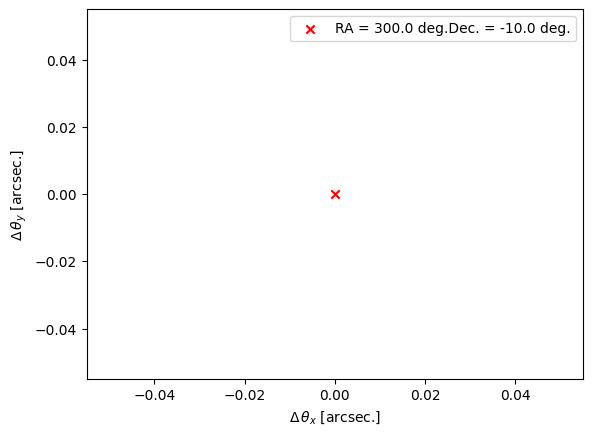

In [2]:
plan = maria.get_plan(scan_pattern="stare",
                      scan_options={},
                    #   scan_options={"radius": 0.25, "speed": 0.5}, # in degrees
                    #   duration=60, # in seconds
                    duration=3,
                    #   sample_rate=225, # in Hz
                    sample_rate=100,
                      start_time = "2022-08-10T06:00:00",
                      scan_center=(300.0, -10.0),
                      frame="ra_dec")
plan.plot()

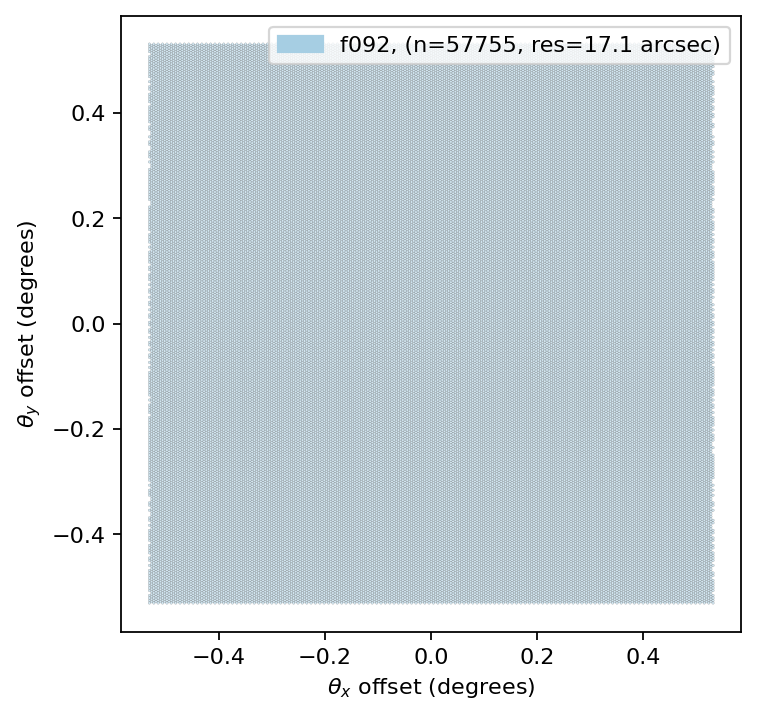

In [3]:
from maria.instrument import Band

f090 = Band(center=92, # in GHz
            width=40.0,
            knee=1,
            sensitivity=6e-5) # in K sqrt(s)

# array = {"field_of_view": 1.0, "bands": [f090]}
# instrument = maria.get_instrument(array=array, primary_size=50, beam_spacing = 2)
# instrument.plot()

# dummy_instrument = maria.get_instrument(array={"field_of_view": 1.0/2.*3.*60., "bands": [f090]}, primary_size=50/60., beam_spacing = 1.0, array_shape="square")
dummy_instrument = maria.get_instrument(array={"field_of_view": 1.0/2.*3., "bands": [f090]}, primary_size=50, beam_spacing = 1.0, array_shape="square")
dummy_instrument.plot()

In [4]:
sim_dummy = maria.Simulation(dummy_instrument,
                       plan=plan,
                       site="llano_de_chajnantor", 
                       map=input_map,
                       noise=False,
                       atmosphere="2d",
                    #    cmb="generate",
                      )

tod_dummy = sim_dummy.run()

2024-08-05 14:06:30.658 INFO: Constructed instrument.
2024-08-05 14:06:30.659 INFO: Constructed plan.
2024-08-05 14:06:30.660 INFO: Constructed site.
2024-08-05 14:06:31.157 INFO: Constructed boresight.
2024-08-05 14:06:31.472 INFO: Constructed offsets.


Initialized base in 814 ms.


Initializing atmospheric layers: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]
Generating atmosphere: 0it [00:00, ?it/s]

self.boresight.time shape: (300,)
layer.sample() shape: (57755, 60)


Generating atmosphere: 1it [00:00,  1.82it/s]

self.boresight.time shape: (300,)
layer.sample() shape: (57755, 60)


Generating atmosphere: 2it [00:01,  1.84it/s]

self.boresight.time shape: (300,)
layer.sample() shape: (57755, 60)


Generating atmosphere: 3it [00:01,  1.84it/s]

self.boresight.time shape: (300,)
layer.sample() shape: (57755, 60)


Generating atmosphere: 4it [00:02,  1.84it/s]


turbulence.shape: (4, 57755, 300)


Computing atm. emission (f092):   0%|          | 0/1 [00:00<?, ?it/s]

det_power_grid shape: (10, 3, 9)


Computing atm. emission (f092): 100%|██████████| 1/1 [00:04<00:00,  4.46s/it]


Emission data['atmosphere'] shape: (57755, 300)


Sampling map (f092):   0%|          | 0/1 [00:00<?, ?it/s]

Here nu: [100.]


Sampling map (f092): 100%|██████████| 1/1 [00:04<00:00,  4.42s/it]


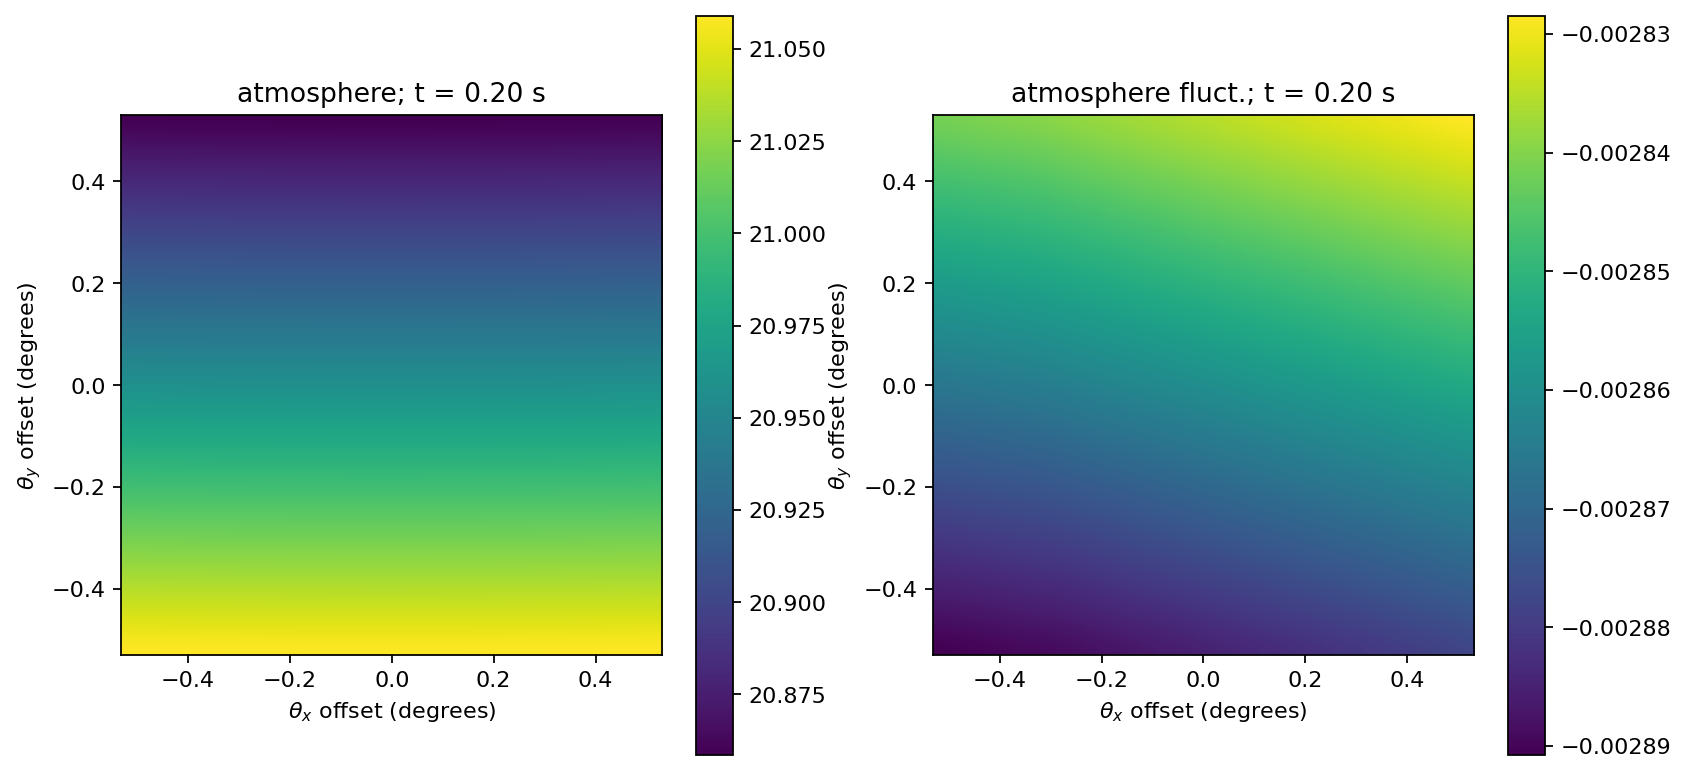

In [93]:
from matplotlib.collections import EllipseCollection
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
# import matplotlib.cm as cm

from maria.tod.coords import Angle

import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import LinearNDInterpolator
import scipy.ndimage as ndimage

cmb_cmap = plt.get_cmap('cmb')

fwhms = Angle(dummy_instrument.fwhm)
offsets = Angle(dummy_instrument.offsets)
atmosphere = tod_dummy.components['atmosphere']
time = tod_dummy.time.compute()

for iub, uband in enumerate(dummy_instrument.ubands):
    band_mask = dummy_instrument.dets.band_name == uband
   
    # atmosphere -= np.mean(atmosphere, axis=1).reshape(len(atmosphere), 1)
    # atmosphere -= np.mean(atmosphere, axis=0).reshape(1, atmosphere.shape[1])

    x, y = getattr(offsets, offsets.units)[band_mask].T
    # cols = atmosphere[:, timestep]

# interpol = LinearNDInterpolator( (x, y), cols, fill_value=np.mean(cols))
interpol = LinearNDInterpolator( (x, y), atmosphere, fill_value=np.mean(atmosphere))

# xpix = np.linspace(x.min(), x.max(), 1000)
# ypix = np.linspace(y.min(), y.max(), 1000)
# imdims = (200, 200)
imdims = (1024, 1024)
xpix = np.linspace(x.min(), x.max(), imdims[0])
ypix = np.linspace(y.min(), y.max(), imdims[1])

xv, yv = np.meshgrid(xpix, ypix)
atmosphere_images = interpol(xv,yv)

# Apply gaussian filter on every atmosphere_images:
for timestep in range(atmosphere_images.shape[2]):
    atmosphere_images[:,:,timestep] = ndimage.gaussian_filter(atmosphere_images[:,:,timestep], (imdims[0]//50, imdims[1]//50))

def plot_time(axes, atmosphere_images, addtext= "data", timestep=0):

        imvals = np.flip(atmosphere_images[:,:,timestep], axis=0)
    
        im0 = axes[0].imshow(imvals, extent=(x.min(), x.max(), y.min(), y.max()))
        axes[0].set_xlabel(rf"$\theta_x$ offset ({offsets.units})")
        axes[0].set_ylabel(rf"$\theta_y$ offset ({offsets.units})")
        axes[0].set_title(f"{addtext}; t = {time[timestep]:.2f} s")
      
        image_fluct = atmosphere_images - np.mean(atmosphere_images, axis=2, keepdims=True)
        imvals_fluct = np.flip(image_fluct[:,:,timestep], axis=0)
        im1 = axes[1].imshow(imvals_fluct, extent=(x.min(), x.max(), y.min(), y.max()))
        axes[1].set_xlabel(rf"$\theta_x$ offset ({offsets.units})")
        axes[1].set_ylabel(rf"$\theta_y$ offset ({offsets.units})")
        axes[1].set_title(f"{addtext} fluct.; t = {time[timestep]:.2f} s")
      
        return im0, im1
  
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=160)   
im0, im1 = plot_time(axes, atmosphere_images, addtext='atmosphere', timestep=20)
fig.colorbar(im0)
fig.colorbar(im1)

# Next we try to run a time-dependent sample_maps on our time-dependent image data

In [94]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import jax
import nifty8.re as jft
import matplotlib.pyplot as plt

from jax import random

seed = 42
key = random.PRNGKey(seed)

In [95]:
# jax compatible rewrite if beams.separably_filter
@jax.jit
def separably_filter(data, F, tol=1e-2, return_filter=False):
    """
    This is more efficient than 2d convolution
    """

    assert data.ndim == 2

    u, s, v = jax.numpy.linalg.svd(F)
    effective_filter = 0
    filtered_image = 0

    # pad data array to achieve mirroring effect
    data = jax.numpy.column_stack([data[:,0], data, data[:, -1]]) # axis=1
    data = jax.numpy.vstack([data[0], data, data[-1]]) # axis=0

    for m in range(len(F)):
        effective_filter += s[m] * u[:, m : m + 1] @ v[m : m + 1]
        
        # Turn kernels into shape (1, dim) to work in nd function
        u_kernel = jax.numpy.broadcast_to(u[:, m], (1, u[:, m].size))
        v_kernel = jax.numpy.broadcast_to(u[:, m], (1, v[m].size))
        
        filtered_image += s[m] * jax.scipy.signal.convolve(jax.scipy.signal.convolve(data, u_kernel.T, mode='same'), v_kernel, mode='same')[1:-1, 1:-1]

    return (filtered_image, effective_filter) if return_filter else filtered_image

In [96]:
@jax.jit
def construct_beam_filter(fwhm, res, buffer=1):
    """
    Make a beam filter for an image.
    """

    # if beam_profile is None:
    #     # beam_profile = lambda r, r0: np.where(r <= r0, 1., 0.)

    #     # a top hat
    #     def beam_profile(r, r0):
    #         return np.exp(-((r / r0) ** 16))

    filter_width = buffer * fwhm

    # n_side = jax.numpy.maximum(filter_width / res, 3).astype(int) # n_side = 3

    filter_side = jax.numpy.linspace(-filter_width / 2, filter_width / 2, 3)
    X, Y = jax.numpy.meshgrid(filter_side, filter_side, indexing="ij")
    R = jax.numpy.sqrt(jax.numpy.square(X) + jax.numpy.square(Y))
    F = jax.numpy.exp(-((R / (fwhm / 2)) ** 16))

    return F / F.sum()

In [390]:
from maria.constants import k_B
from maria.instrument import beams

# @jax.jit
def sample_maps(sim_truthmap, instrument, dx, dy, resolution, x_side, y_side):

    data_map = jax.numpy.array(1e-16 * np.random.standard_normal(size=dx.shape))
    pbar = instrument.bands

    for band in pbar:
        band_mask = instrument.dets.band_name == band.name

        # nu = jax.numpy.linspace(band.nu_min, band.nu_max, 64)
        # TRJ = jax.scipy.interpolate.RegularGridInterpolator(
        #     (jax.numpy.array([100.]),),
        #     sim_truthmap,
        #     fill_value=None,
        #     bounds_error=False,
        #     method='nearest',
        # )(nu)

        # print(TRJ.shape)

        # nu_passband = jax.numpy.exp(jax.numpy.log(0.5) * (2 * (nu - 90.) / 30.) ** 2)
        # power_map = (
        #     1e12
        #     * k_B
        #     * jax.numpy.trapezoid(nu_passband[:, None, None] * TRJ, axis=0, x=1e9 * nu)
        # )

        # # nu is in GHz, f is in Hz
        # nu_fwhm = beams.compute_angular_fwhm(
        #     # fwhm_0=sim_truthmap.instrument.dets.primary_size.mean(),
        #     fwhm_0=instrument.dets.primary_size.mean(),
        #     z=np.inf,
        #     f=1e9 * band.center,
        # ) 
        
        # nu_map_filter = construct_beam_filter(fwhm=nu_fwhm, res=resolution)
        # filtered_power_map = separably_filter(power_map, nu_map_filter)
        
        for i in range(dx.shape[1]):
        
            # combined_points = jax.numpy.stack( (jax.numpy.array(dx[band_mask]), jax.numpy.array(dy[band_mask])) , axis=-1)
            # combined_points_reshaped = combined_points.reshape(-1, 2)
            map_power = jax.scipy.interpolate.RegularGridInterpolator(
                # Need to invert x_side and y_side for jax interpolation:
                # (jax.numpy.flip(x_side), jax.numpy.flip(y_side)), # length N=2 sequence of arrays with grid coords
                (x_side, y_side), # length N=2 sequence of arrays with grid coords
                # sim_truthmap[0],
                sim_truthmap[0, :, :, i],
                # jax.numpy.flip(sim_truthmap[0, :, :, i]),
                # sim_truthmap[0],
                # filtered_power_map, # N=2-dimensional array specifying grid values (1000, 1000)
                fill_value=0.,
                bounds_error=False,
                method="linear",
            # )((jax.numpy.array(dx[band_mask][:,i]), jax.numpy.array(dy[band_mask][:,i])))
            )((jax.numpy.array(dx[band_mask,i]), jax.numpy.array(dy[band_mask,i])))

            # jax.debug.print("Total map power: {pwr}", pwr=map_power.sum())


            #time-indep:
            # data_map = data_map.at[band_mask].add(map_power)
            #time-dep
            data_map = data_map.at[band_mask, i].add(map_power)
        

        
    # return sim_truthmap.data["map"]
    return data_map

# Test TOD agreement

In [391]:
# Will need real simulation later. For validation, first run ONLY on dummy!
# sim_atmosphere = maria.Simulation(instrument, 
#                                 plan=plan,
#                                 site="llano_de_chajnantor", 
#                                 map=input_map,
#                                 noise=False,
#                                 atmosphere="2d",
#                                 # cmb="generate",
#                                 )

# tod_atmosphere = sim_atmosphere.run()

In [392]:
# dx, dy = sim_atmosphere.coords.offsets(frame=sim_atmosphere.map.frame, center=sim_atmosphere.map.center)
dx, dy = sim_dummy.coords.offsets(frame=sim_dummy.map.frame, center=sim_dummy.map.center)
dx = dx.compute()
dy = dy.compute()

print(dx.shape)

(57755, 300)


In [393]:
atmosphere_images.shape

(1024, 1024, 300)

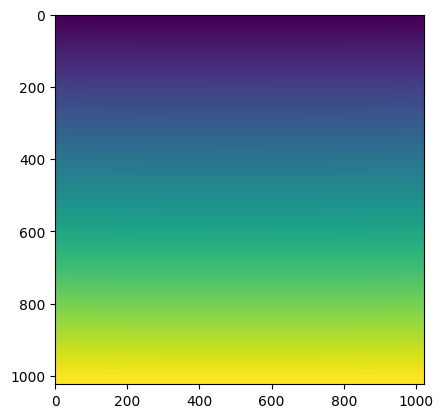

In [394]:
plt.imshow(np.flip(atmosphere_images)[:, :, 0])

In [400]:
# jax_tods = sample_maps(atmosphere_images[:,:,0][np.newaxis, :, :], dummy_instrument, dx, dy, sim_dummy.map.resolution, sim_dummy.map.x_side, sim_dummy.map.y_side)
jax_tods = sample_maps(atmosphere_images[np.newaxis, :, :, :], dummy_instrument, dx, dy, sim_dummy.map.resolution, sim_dummy.map.x_side, sim_dummy.map.y_side)

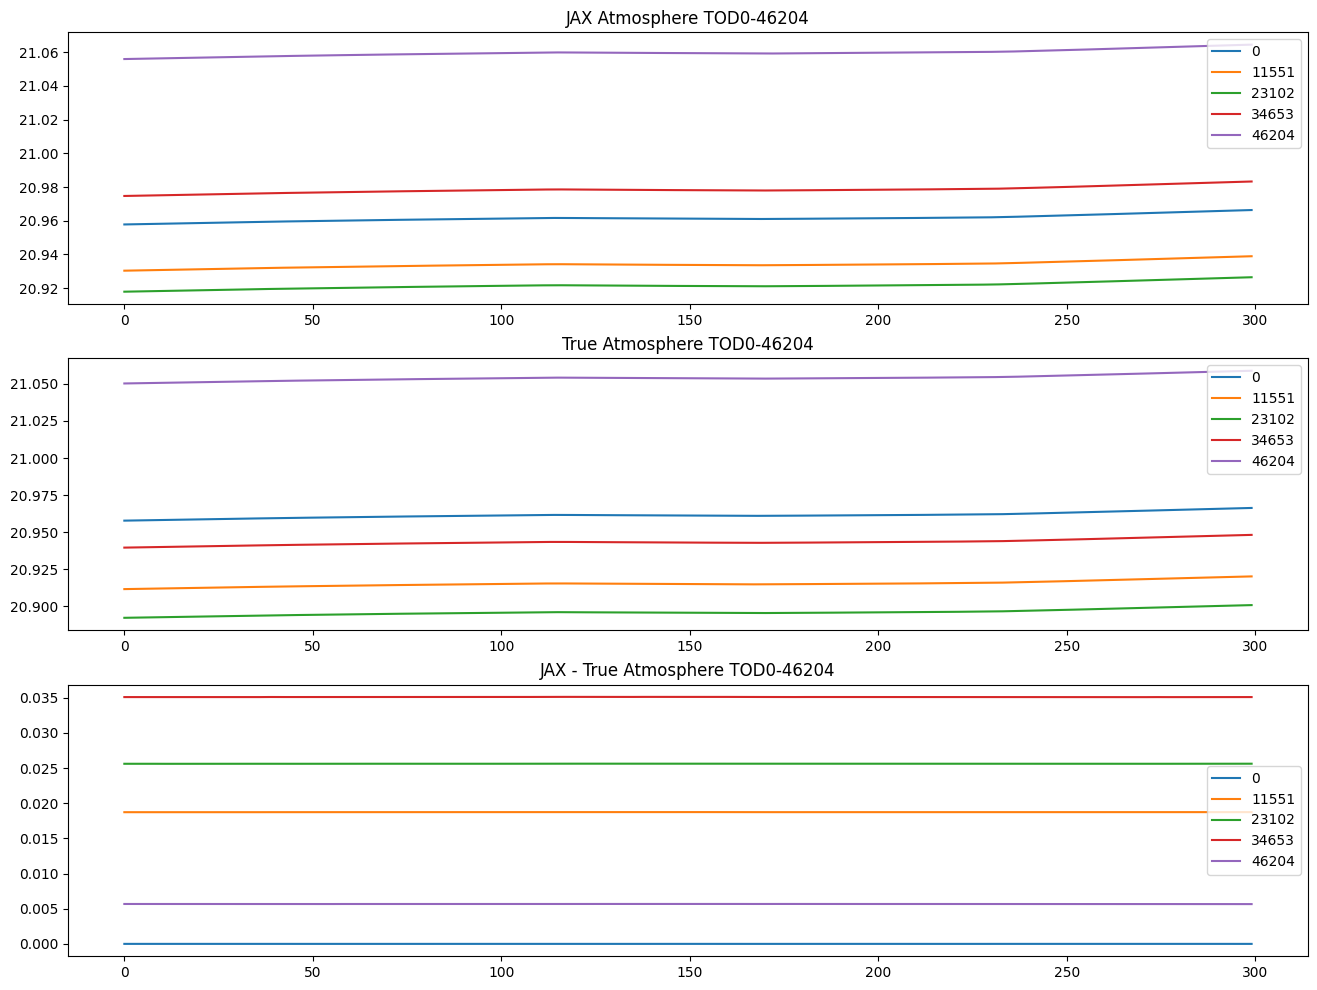

In [402]:
fig, axes = plt.subplots(3, 1, figsize=(2*8, 1.5*8))

for i in range(0, len(dx), len(dx)//5):
    im0 = axes[0].plot(jax_tods[i], label=i)

    # tod_atmosphere_truth = np.float64(tod_atmosphere.components['atmosphere'].compute())
    tod_atmosphere_truth = np.float64(tod_dummy.components['atmosphere'].compute())
    im1 = axes[1].plot(tod_atmosphere_truth[i], label=i)
    
    im2 = axes[2].plot(jax_tods[i] - tod_atmosphere_truth[i], label=i)
    
axes[0].title.set_text(f'JAX Atmosphere TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True Atmosphere TOD0-{i}')
axes[1].legend()
axes[2].title.set_text(f'JAX - True Atmosphere TOD0-{i}')
axes[2].legend()

plt.show()